In [1]:
using QuantumOptics
using NBInclude
using Einsum
#using DataFrames
using LinearAlgebra
# lattice
@nbinclude("Lattice_Basis_Neighbors_Hops.ipynb"; regex=r"#.*executeme")
# mb tools
@nbinclude("QOJulia_utils.ipynb")

proj_MB_Int (generic function with 1 method)

In [2]:
param_dict=Dict{}()

LL = [8,10]
N = LL[1]*LL[2]
vv_lattice = [ [1., 0], [0, 1.] ]
b1=[0, 0]
vv_basis = [b1]
param_dict["N"] = LL[1]*LL[2]

param_dict["LL"] = LL
param_dict["vv_lattice"] = vv_lattice
param_dict["vv_basis"] = vv_basis

nb=1 # number of basis
t=-1 # hopping amplitude
p=1
q=LL[2]
ϕ=p/q # magnetic flux per plaquet
param_dict["gauge"] = "Landau"
param_dict["t"]=t
param_dict["ϕ"]=ϕ
θθ = [0, 0] # initial values for twist angles
param_dict["θθ"]=θθ

sites, site_coord, site_number = get_sites(LL, vv_lattice, vv_basis);
param_dict["sites"] = sites
param_dict["site_coord"] = site_coord
param_dict["site_number"] = site_number

pbc=true # periodic boundary condition
param_dict["pbc"] = pbc
neighbors = [ [1, 0, 1], [-1, 0, 1], [0, 1, 1], [0, -1, 1]  ]
neighbors_list = [ neighbors ]
param_dict["neighbors_list"] = neighbors_list

1-element Vector{Vector{Vector{Int64}}}:
 [[1, 0, 1], [-1, 0, 1], [0, 1, 1], [0, -1, 1]]

In [3]:
function Vpin(site, V0, site_number, LL)
        i_site = site_number[site]
        dimH = LL[1]*LL[2]
        VV   = zeros(dimH,dimH)
        VV[i_site, i_site] = -V0
        return VV
end

Vpin (generic function with 1 method)

In [4]:
function Vimp(sites,VV0,site_number,LL)
    dimH = LL[1]*LL[2]
    VM   = zeros(dimH,dimH)
    for (site, V0) in zip(sites,VV0) 
        VM += Vpin(site, V0, site_number, LL)
    end
    return VM
end

Vimp (generic function with 1 method)

In [40]:
mutable struct impurity
           V0::Float64
           pos::Array{Float64}
           wid::Float64
end

In [41]:
imp1 = impurity(1, [5,5], 2)

impurity(1.0, [5.0, 5.0], 2.0)

In [60]:
imp1.V0

5.0

In [45]:
norm( site_coord[sites[2]] - imp1.pos )

6.4031242374328485

In [242]:
function Vpin2(imp, sites, site_number, site_coord, LL)
        #xc, yc = site_coord[imp_site]
        dimH = LL[1]*LL[2]
        VV   = zeros(dimH,dimH)
        for site in sites
            i_site = site_number[site]
            VV[i_site, i_site] = imp.V0*(tanh( norm( site_coord[site] - imp.pos )/imp.wid )^2-1)
        end
        return VV
end

Vpin2 (generic function with 2 methods)

In [243]:
function Vimp2(imps, sites, site_number, site_coord, LL)
    dimH = LL[1]*LL[2]
    VM   = zeros(dimH,dimH)
    for imp in imps 
        VM +=  Vpin2(imp, sites, site_number, site_coord, LL)
    end
    return VM
end

Vimp2 (generic function with 2 methods)

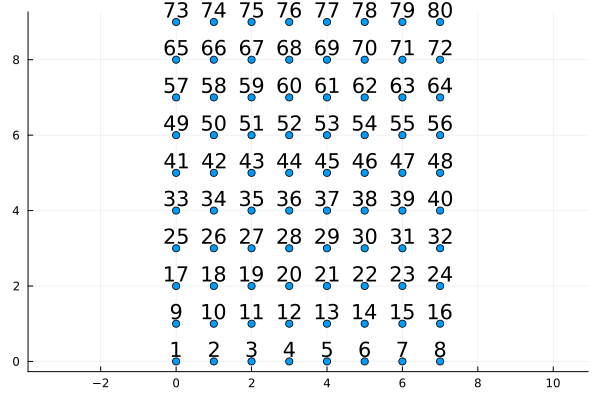

In [244]:
plot_points(sites, site_coord, site_number)

In [245]:
imp_site = sites[44]

3-element Vector{Int64}:
 3
 5
 1

In [246]:
xc, yc = site_coord[ imp_site ]

2-element Vector{Float64}:
 3.0
 5.0

In [257]:
V0 = 5
w = .5
imp1 = impurity(V0, [5,5], w)
#VimpM = Vpin(imp_site, V0, site_number, LL);
VimpM = Vpin2(imp1, sites, site_number, site_coord, LL);

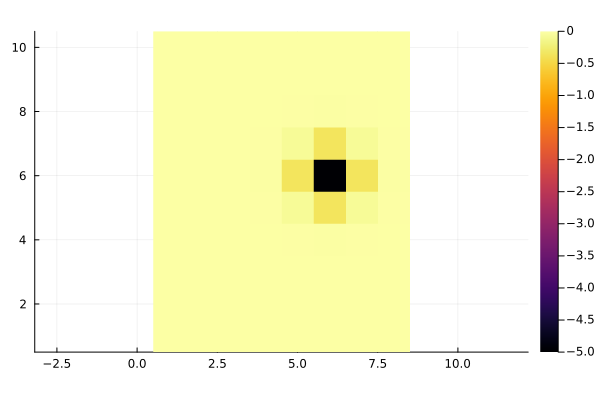

In [258]:
heatmap(reshape(diag(VimpM),8,10)', aspect_ratio=1)

In [80]:
imp_sites = [ sites[22], sites[60] ]
imp1 = impurity(5, [2,7], .5)
imp2 = impurity(10, [5,2], .5)
imps = [imp1, imp2]

2-element Vector{impurity}:
 impurity(5.0, [2.0, 7.0], 0.5)
 impurity(10.0, [5.0, 2.0], 0.5)

In [81]:
#VimpM = Vimp(imp_sites, VV0, site_number, LL);
VimpM = Vimp2(imps, sites, site_number, site_coord, LL);

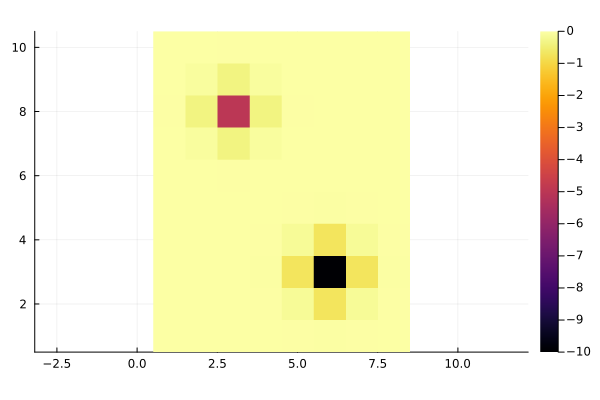

In [82]:
heatmap(reshape(diag(VimpM),8,10)', aspect_ratio=1)

In [83]:
basis = NLevelBasis(N) 
param_dict["basis"] = basis;

param_dict["model_H1"] = get_Hofstadter_hamiltonian

H_T = get_Hofstadter_hamiltonian(param_dict)
H_Kin = get_sp_op(basis, H_T)
Vimp_op = get_sp_op(basis, VimpM);

In [84]:
function Himp(imps, H_Kin)
    VimpM = Vimp2(imps, sites, site_number, site_coord, LL);
    Vimp_op = get_sp_op(basis, VimpM)
    return H_Kin + Vimp_op
end

Himp (generic function with 1 method)

In [196]:
EE_Kin, UU_Kin = eigen(dense(H_Kin).data);

imps = [ impurity(2, [2,7], .5), 
         impurity(2.0001, [5,2], .5)]

H1 = Himp(imps, H_Kin)
EE, UU = eigen(dense(H1).data);
EE, UUS = eigenstates(dense(H1));

imps = [ impurity(1, [2,7], .5), 
         impurity(0, [5,2], .5)]
H1 = Himp(imps, H_Kin)
EE2, UU2 = eigen(dense(H1).data);
EE2, UUS2 = eigenstates(dense(H1));

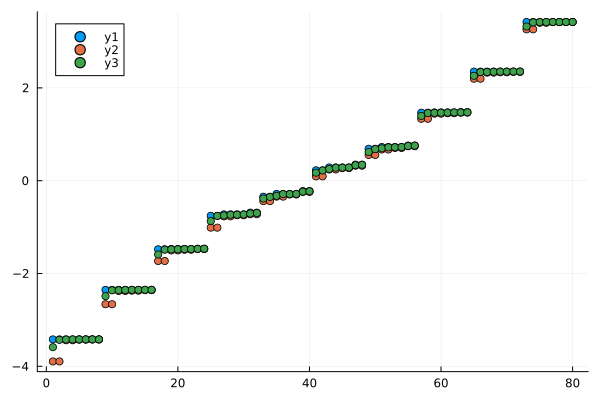

In [197]:
scatter(EE_Kin)
scatter!(EE)
scatter!(EE2)
#ylims!(-4,-3)

In [198]:
EE[1:3]

3-element Vector{Float64}:
 -3.894641523645306
 -3.8946014529247104
 -3.4382825112818725

In [199]:
function calc_pr(state)
    return sum( ( real( diag( dm(state).data ) ) ).^2 )
end

calc_pr (generic function with 1 method)

In [200]:
prs=[]
prs2=[]
for i in 1:prod(LL)
    pr = calc_pr(UUS[i])
    push!(prs,pr)
    pr = calc_pr(UUS2[i])
    push!(prs2,pr)
end

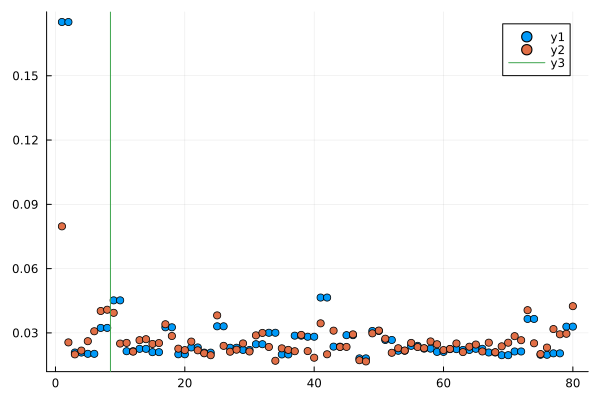

In [201]:
scatter(prs)
scatter!(prs2)
vline!([8.5])

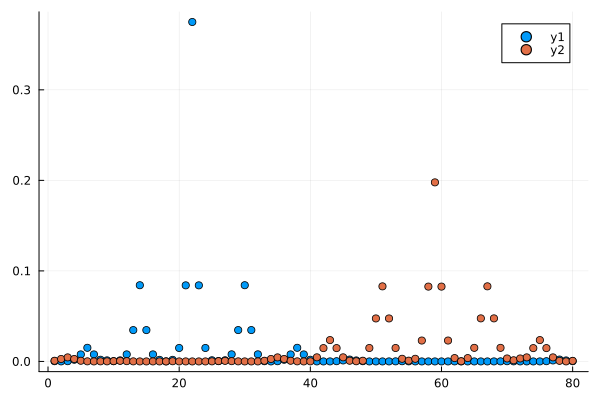

In [202]:
scatter(  real( diag( dm(UUS[1]).data ) ) )
scatter!(  real( diag( dm(UUS2[1]).data ) ) )

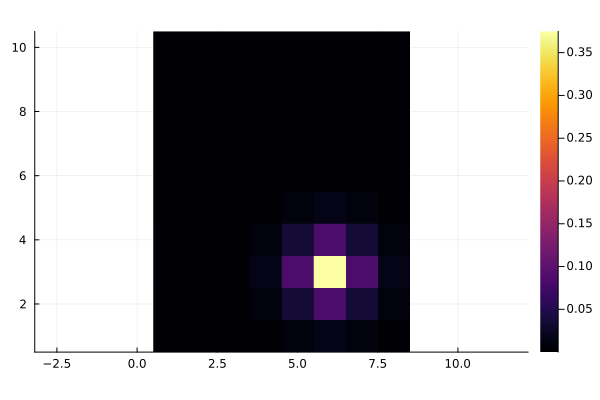

In [203]:
heatmap(reshape(real( diag( dm(UUS[1]).data ) ),8,10)', aspect_ratio=1)

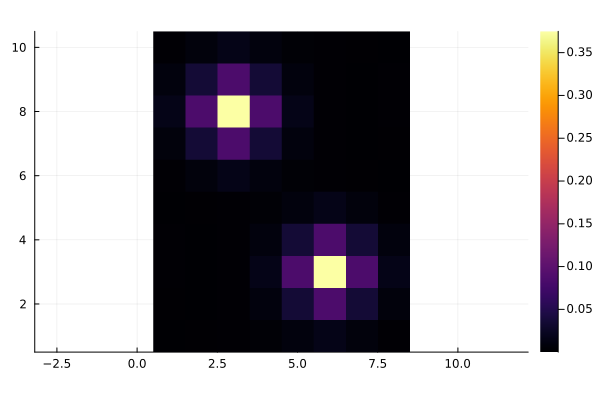

In [204]:
heatmap(reshape(real( diag( dm(UUS[1]).data+dm(UUS[2]).data ) ),8,10)', aspect_ratio=1)

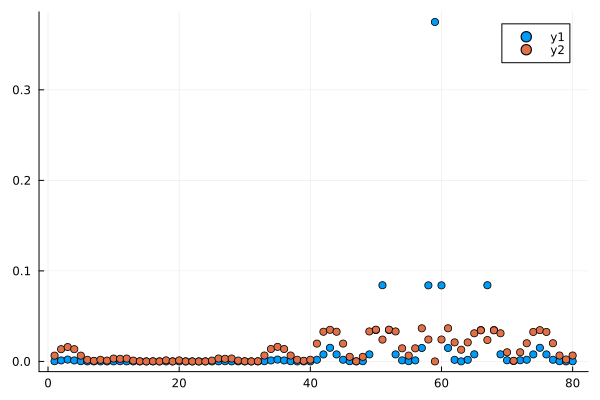

In [205]:
scatter(  real( diag( dm(UUS[2]).data ) ) )
scatter!(  real( diag( dm(UUS2[2]).data ) ) )

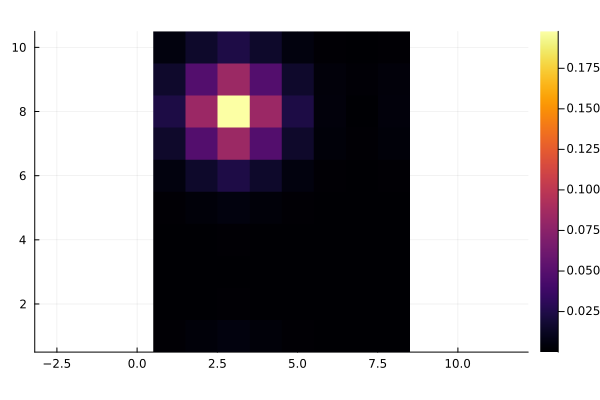

In [206]:
heatmap(reshape(real( diag( dm(UUS2[1]).data ) ),8,10)', aspect_ratio=1)

# Path

In [155]:
function circular_path(θ,center,radius)
    return [center[1]+radius*cos(θ), center[2]+radius*sin(θ)]
end

circular_path (generic function with 1 method)

In [278]:
center = [4,4]
radius = 3 
θ = pi/4

imp_pos = circular_path(θ,center,radius)
imp_pos2 = circular_path(θ+pi,center,radius)

V0 = 1
w0 = 1

imps = [ impurity(1.1*V0, imp_pos2, w0), 
         impurity(V0, imp_pos, w0) ]

H1 = Himp(imps, H_Kin)
EE, UU = eigen(dense(H1).data);
EE, UUS = eigenstates(dense(H1));

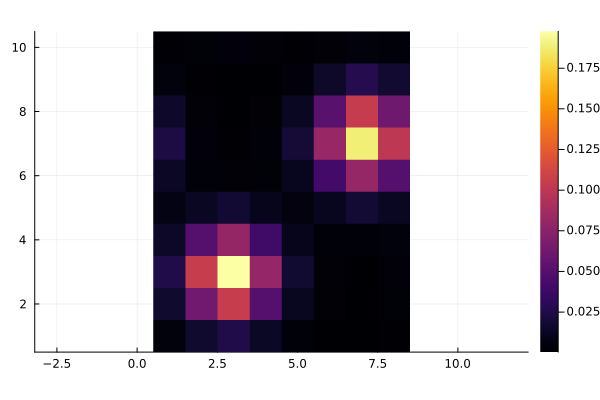

In [279]:
heatmap(reshape(real( diag( dm(UUS[1]).data+dm(UUS[2]).data ) ),8,10)', aspect_ratio=1)

# Projection

In [301]:
param_dict["sub_range"] = 1:LL[1]

sub_states = get_subset_states(H_Kin, param_dict["sub_range"]);
subspace_proj, P, Pt = get_projector_op(basis, sub_states);
H1_proj = get_subspace_op(H1, P, Pt);
H1_proj = (H1_proj+H1_proj')/2;

In [302]:
EE_sub, UU_sub = eigen(dense(H1_sub).data);
EE_sub, UUS_sub = eigenstates(dense(H1_sub));

In [303]:
println( EE[1:3] )
println( EE_sub[1:3] )

[-3.7980128067770003, -3.7543613772972306, -3.536858241721465]
[-3.732008470224109, -3.6985373156875045, -3.524893248215101]


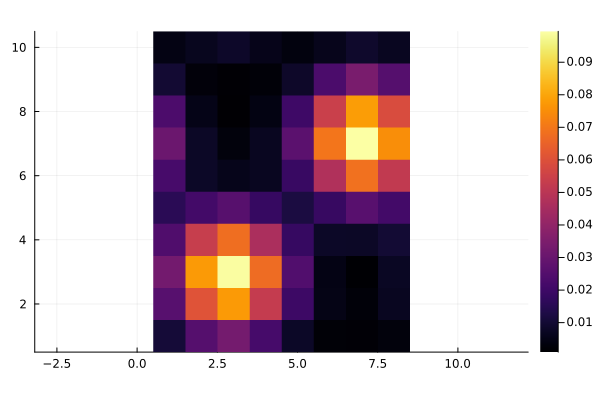

In [304]:
heatmap(reshape(real( diag( dm(Pt*UUS_sub[1]).data+dm(Pt*UUS_sub[2]).data ) ),8,10)', aspect_ratio=1)

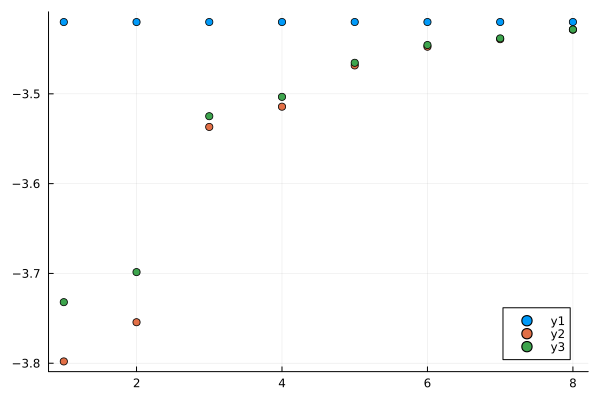

In [305]:
scatter(EE_Kin[1:LL[1]])
scatter!(EE[1:LL[1]])
scatter!(EE_sub)

In [306]:
param_dict["projection"] = subspace_proj, P, Pt;

In [327]:
param_dict["PN"] = [3]
basis_mb = get_basis_mb(param_dict)
param_dict["dimH_mb"] = length(basis_mb)

120

In [328]:
H1_NI_mb = get_mb_op(basis_mb, H1_proj);

In [329]:
EE_mb, UU_mb = eigen(dense(H1_mb).data);
EE_mb[1:5]

5-element Vector{Float64}:
 -11.19602541067233
 -11.162554256135724
 -11.129083101599116
 -11.095611947062508
 -10.988910188663318

In [318]:
EE_sub[1]*3

-11.196025410672327

In [320]:
N

80

LoadError: BoundsError: attempt to access 8-element Vector{Int64} at index [9]